In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [45]:
import talib

# Load data

In [46]:
data = pd.read_csv('../data/data_lexical_decision.csv', sep=',', header=0, index_col=0)

In [47]:
def inspect_person(which_id=2, plot_raw=False, figsize=(16, 6)):
    """
    Plot RT (summaries) over time for a given person id.
    """
    
    person = data[data.id == which_id].sort_values(['session', 'block', 'trial'])
    
    f, ax = plt.subplots(1, 1, figsize=figsize)
    time = np.arange(person.shape[0])
    
    if plot_raw:
        ax.plot(time, person.rt, alpha=0.2, label='Raw RTs')
    ax.plot(time, talib.EMA(person.rt, timeperiod=100), color='red', lw=3, label='EMA100')
    ax.plot(time, talib.EMA(person.rt, timeperiod=50), color='green', lw=2, label='EMA50', alpha=0.5)
    ax.plot(time, talib.EMA(person.rt, timeperiod=9), color='blue', lw=1, label='EMA9', alpha=0.2)

    for idx in np.argwhere(person.session.diff().values == 1):
        ax.axvline(idx, color='black', linestyle='dashed', alpha=0.5)
    sns.despine(ax=ax)
    ax.grid(alpha=0.2)
    ax.legend()

# Simulator

In [48]:
def dynamic_prior(batch_size, **args):
    """
    Generates a random draw from the diffusion model prior.
    """
    
    v1 = np.random.uniform(0.3, 6.0, batch_size)
    v2 = np.random.uniform(0.3, 6.0, batch_size)
    a = np.random.uniform(0.3, 2.5, batch_size)
    ndt = np.random.uniform(0.1, 1.6, batch_size)
    v1_s = np.random.uniform(0.01, 0.1, batch_size)
    v2_s = np.random.uniform(0.01, 0.1, batch_size)
    a_s = np.random.uniform(0.01, 0.1, batch_size)
    ndt_s = np.random.uniform(0.01, 0.1, batch_size)
    return np.c_[v1, v2, a, ndt, v1_s, v2_s, a_s, ndt_s]

def context_gen(batch_size, n_obs):
    return np.random.randint(0, 2, (batch_size, n_obs)).astype(np.float32)

@njit
def diffusion_trial(v, a, ndt, zr=0.5, dt=0.001, s=1.0, max_iter=1e4):
    """
    Simulates a single reaction time from a simple drift-diffusion process.
    """

    n_iter = 0
    x = a * zr
    c = np.sqrt(dt * s)
    
    while x > 0 and x < a:
        
        # DDM equation
        x += v*dt + c * np.random.randn()
        
        n_iter += 1
        
    rt = n_iter * dt
    return rt+ndt if x > 0 else -(rt+ndt)


@njit
def dynamic_diffusion_process(prior_samples, exp_context, n_obs, dt=0.001, s=1.0, max_iter=1e4):
    """
    Performs one run of a dynamic diffusion model process.
    """
    
    params, params_stds = np.split(prior_samples, 2, axis=-1)
    params_t = params
    
    params_t_array = np.zeros((n_obs, params.shape[0]))
    
    # Draw first param combination from prior
    rts_v = np.zeros(n_obs)
    
    # Iterate over number of trials
    for t in range(n_obs):
        
        # Run diffusion process
        
        rts_v[t] = diffusion_trial(params_t[exp_context[t]], params_t[2], params_t[3])
        
        # Store before transition
        params_t_array[t] = params_t
        
        # Transition and ensure non-negative parameters
        params_t = params_t + params_stds * np.random.randn(params.shape[0])
        
        # Constraints
        params_t[0] = min(max(params_t[0], 0.3), 6)
        params_t[1] = min(max(params_t[1], 0.3), 6)
        params_t[2] = min(max(params_t[2], 0.3), 2.5)
        params_t[3] = min(max(params_t[3], 0.1), 1.6)
        
    return np.atleast_2d(rts_v).T, params_t_array, params_stds

@njit
def batch_simulator(prior_samples, context, n_obs, dt=0.001, s=1.0, max_iter=1e4):
    
    B = prior_samples.shape[0]
    X = np.zeros((B, n_obs, 1))
    theta_d = np.zeros((B, n_obs, 4))
    theta_s = np.zeros((B, 4))
    for bi in range(B):
        
        X[bi], theta_d[bi], theta_s[bi] = dynamic_diffusion_process(prior_samples[bi], 
                                                                    context[bi],
                                                                    n_obs,
                                                                    dt=dt, s=s, 
                                                                    max_iter=max_iter)
    return X, theta_d, theta_s

# Amortizers

## Network Architecture

In [49]:
class HeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.IndependentNormal.params_size(n_params_d)),
            tfpl.IndependentNormal(n_params_d)
        ])
        
    def call(self, x):
        """
        Forward pass through the model.
        """
        
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic stuff
        preds_dyn = self.dynamic_predictor(rep)
     
        return preds_dyn

## Loss

In [50]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

## Epoch helper

In [51]:
def train_epoch(network, optimizer, batch_size, steps_per_epoch, p_bar):
    
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
        
            # Simulate from model
            prior_draws = dynamic_prior(batch_size)
            context = context_gen(batch_size, N_OBS)
            x_t, params_t, _= batch_simulator(prior_draws, context.astype(np.int32), N_OBS)
            net_in = tf.concat((x_t, context[:, :, np.newaxis]), axis=-1)
            pred_params_t = network(net_in)

            # Loss dynamic and static
            loss_d = nll(params_t, pred_params_t)
            
            total_loss = loss_d
        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)

## Train

In [15]:
N_OBS = 120

In [20]:
epochs = 50
batch_size = 32
steps_per_epoch = 1000
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate)
network = HeteroscedasticNetwork(4)

In [23]:
# change learning rate
# epochs = 10
# learning_rate = 0.00005
# optimizer = tf.keras.optimizers.Adam(learning_rate)

In [24]:
for ep in range(1, epochs+1):
    with tqdm(total=steps_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        train_epoch(network, optimizer, batch_size, steps_per_epoch, p_bar)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
# network.save_weights('checkpoints/dynamic_third')

In [83]:
def plot_dynamic_posterios(dynamic_posterior, par_labels, par_names, 
                           ground_truths=None, color_pred='#884da3'):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
    
    assert len(dynamic_posterior.shape) == 3, "Dynamic posterior should be 3-dimensional!" 
    assert ground_truths is None or len(ground_truths.shape) == 2,'Ground truths should be 2-dimensional!'
    assert dynamic_posterior.shape[0] == 1, "Function assumes dynamics posterior for a single data set!" 
        
    means = dynamic_posterior.mean()[0]
    std = dynamic_posterior.stddev()[0]
    
    sigma_factors = [1]
    alphas = [0.6]
    
    time = np.arange(x_t.shape[1])
    f, axarr = plt.subplots(2, 2, figsize=(18, 8))
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(time, means[:, i], color=color_pred, label='Posterior Mean')
        for sigma_factor, alpha in zip(sigma_factors, alphas):
            ci_upper = means[:, i] + sigma_factor * std[:, i]
            ci_lower = means[:, i] - sigma_factor * std[:, i]
            ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha)
        if ground_truths is not None:
            ax.plot(time, ground_truths[:, i], color='black', linestyle='dashed', label='True Dynamic', lw=2)
        sns.despine(ax=ax)
        ax.grid(alpha=0.15)
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Parameter value ({})'.format(par_names[i]), fontsize=12)
        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=12)
        
        if i == 0:
            f.legend()
    
    f.tight_layout()

In [94]:
n_test = 6
prior_draws = dynamic_prior(n_test)
context_draws = context_gen(n_test, N_OBS)
x_t, params_t, params_s = batch_simulator(prior_draws, context_draws.astype(np.int32), N_OBS)
x_in = np.concatenate((x_t, context_draws[:, :, np.newaxis]), axis=-1)

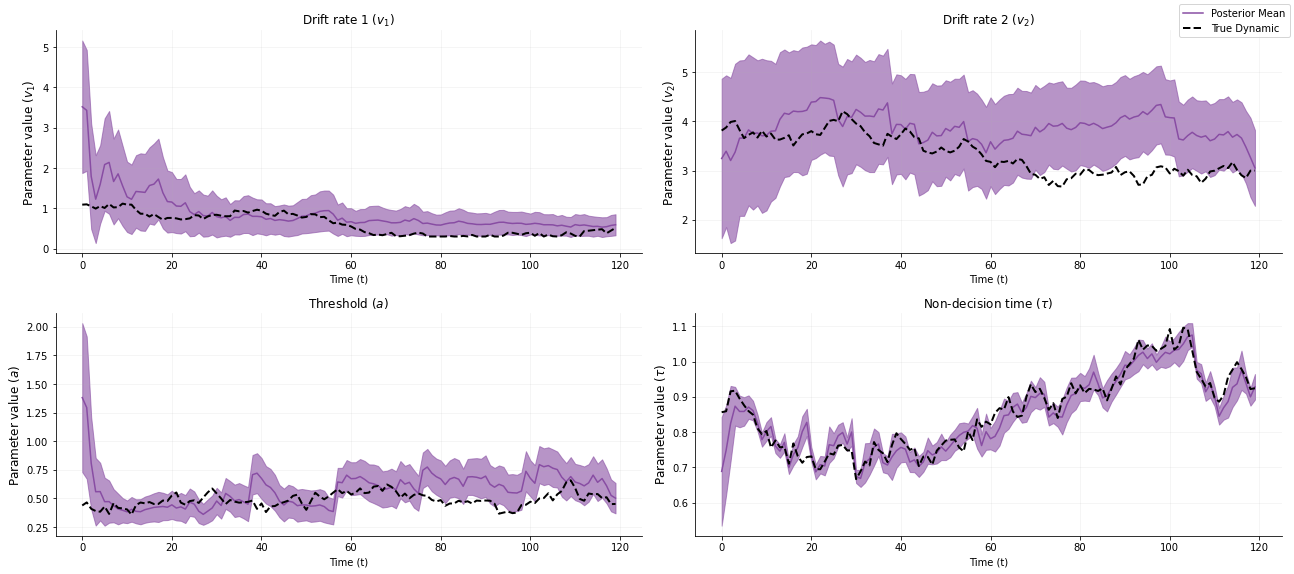

In [95]:
which = 0
dynamic_posterior = network(x_in[which:(which+1)])
ground_truths = params_t[which]
par_labels = ['Drift rate 1', 'Drift rate 2', 'Threshold', 'Non-decision time']
par_names = [r'$v_1$', r'$v_2$', r'$a$', r'$\tau$']
plot_dynamic_posterios(dynamic_posterior, par_labels,  par_names, ground_truths)

# Inference

In [136]:
@njit
def dynamic_generator(params_t, n_obs, dt=0.001, s=1.0, max_iter=1e4):
    """
    Performs one run of a dynamic diffusion model process.
    """
    
    rts_v = np.zeros(n_obs)
    for t in range(n_obs):
        rts_v[t] = diffusion_trial(params_t[t, EXP_STRUCTURE[t]], params_t[t, 4], params_t[t, 5])
    return rts_v

In [194]:
rts = person.rt.values.copy()
acc = person.acc.values.copy()

In [195]:
rts[acc == 0] = -rts[acc == 0]

In [196]:
x_nn = rts[np.newaxis, :, np.newaxis]

In [197]:
post_t, post_s = network(x_nn)

In [146]:
# post_t_mean = np.exp(post_t.mean())
# post_s_mean = np.exp(post_s.mean())

In [219]:
sim_data = []
n_sim = 20
n_post_samples = 20
post_samples_t = np.exp(post_t.sample(n_post_samples))[:, 0, :, :]
for pi in range(n_post_samples):
    for _ in range(n_sim):
        x_pred = dynamic_generator(post_samples_t[pi], N_OBS)
        sim_data.append(talib.SMA(np.abs(x_pred), timeperiod=5))
sim_data = np.abs(np.array(sim_data))

In [220]:
quantiles = np.quantile(sim_data, [0.05, 0.95], axis=0)
median = np.median(sim_data, axis=0)
mean = np.mean(sim_data, axis=0)

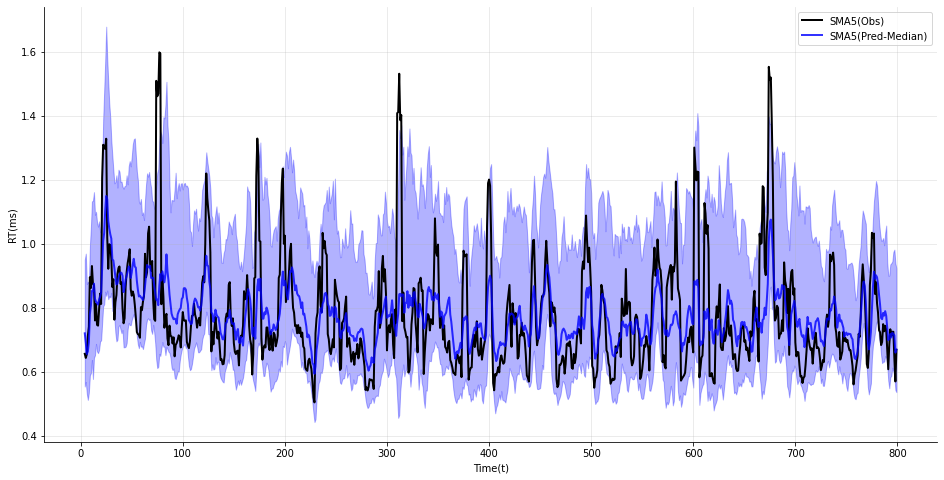

In [223]:
# Initialize figure
f, ax = plt.subplots(1, 1, figsize=(16, 8))

# Plot observed
time = np.arange(x_nn.shape[1])
ax.plot(time, talib.SMA(np.abs(x_nn[0, :, 0]), timeperiod=5), color='black', lw=2, label='SMA5(Obs)')
ax.plot(time, median, color='blue', lw=2, label='SMA5(Pred-Median)', alpha=0.8)
ax.fill_between(time, quantiles[0, :], quantiles[1, :], color='blue', alpha=0.3)
sns.despine(ax=ax)
ax.grid(alpha=0.3)
ax.set_ylabel('RT(ms)')
ax.set_xlabel('Time(t)')
ax.legend()